In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from gensim import corpora, models
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

True

2. Data Collection

In [5]:
TRAIN_PATH  = '/kaggle/input/traindata/Corona_NLP_train.csv'
TEST_PATH   = '/kaggle/input/testdata/Corona_NLP_test (1).csv'

df_train = pd.read_csv(TRAIN_PATH, encoding='latin-1')
df_test  = pd.read_csv(TEST_PATH,  encoding='latin-1')

print("Train samples:", len(df_train), "Test samples:", len(df_test))

Train samples: 41157 Test samples: 3798


3. Data Cleaning & Preprocessing

In [7]:
df = pd.concat([df_train, df_test], ignore_index=True)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'[^a-z\s]', '', text)
    return text

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

df['ProcessedTweet'] = df['OriginalTweet'].apply(preprocess)

4. Text Representation

In [9]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'[^a-z\s]', '', text)
    return text

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['ProcessedTweet'] = df['OriginalTweet'].apply(preprocess)
print("Preprocessed samples：")
display(df[['OriginalTweet','ProcessedTweet']].head())


Preprocessed samples：


,OriginalTweet,ProcessedTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,
1,advice Talk to your neighbours family to excha...,advice talk neighbour family exchange phone nu...
2,Coronavirus Australia: Woolworths to give elde...,coronavirus australia woolworth give elderly d...
3,My food stock is not the only one which is emp...,food stock one empty please dont panic enough ...
4,"Me, ready to go at supermarket during the #COV...",ready go supermarket outbreak im paranoid food...


5. Sentiment Analysis

In [10]:
def get_sentiment_score(text):
    return TextBlob(text).sentiment.polarity

df['SentimentScore'] = df['ProcessedTweet'].apply(get_sentiment_score)
df['SentimentLabel'] = df['SentimentScore'].apply(
    lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral')
)
print("Distribution ：")
display(df['SentimentLabel'].value_counts())

Distribution ：


SentimentLabel
Positive    20213
Neutral     13367
Negative    11375
Name: count, dtype: int64

6. Topic Modeling by Sentiment Group

In [11]:
def lda_topics(texts, num_topics=3, num_words=5):
    tokenized = [doc.split() for doc in texts]
    dictionary = corpora.Dictionary(tokenized)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized]
    lda = models.LdaModel(corpus, id2word=dictionary,
                          num_topics=num_topics, passes=10, random_state=42)
    return lda.print_topics(num_words=num_words)

positive_texts = df[df['SentimentLabel']=='Positive']['ProcessedTweet'].tolist()
negative_texts = df[df['SentimentLabel']=='Negative']['ProcessedTweet'].tolist()

print("=== Positive Topics ===")
for topic in lda_topics(positive_texts):
    print(topic)

print("=== Negative Topics ===")
for topic in lda_topics(negative_texts):
    print(topic)

=== Positive Topics ===
(0, '0.025*"price" + 0.025*"covid" + 0.019*"consumer" + 0.009*"demand" + 0.009*"food"')
(1, '0.027*"store" + 0.019*"online" + 0.018*"grocery" + 0.017*"shopping" + 0.013*"covid"')
(2, '0.018*"food" + 0.016*"supermarket" + 0.014*"panic" + 0.014*"people" + 0.013*"hand"')
=== Negative Topics ===
(0, '0.034*"price" + 0.020*"covid" + 0.014*"due" + 0.013*"online" + 0.009*"oil"')
(1, '0.023*"store" + 0.020*"people" + 0.019*"supermarket" + 0.019*"grocery" + 0.012*"toilet"')
(2, '0.026*"food" + 0.022*"covid" + 0.017*"consumer" + 0.012*"price" + 0.011*"supply"')


LDA

In [17]:
from gensim import corpora, models
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# positive LDA
tokenized_pos = [doc.split() for doc in positive_texts]
positive_dict = corpora.Dictionary(tokenized_pos)
pos_corpus   = [positive_dict.doc2bow(doc) for doc in tokenized_pos]
positive_lda = models.LdaModel(pos_corpus,
                               id2word=positive_dict,
                               num_topics=3,
                               passes=10,
                               random_state=42)

# negative LDA
tokenized_neg = [doc.split() for doc in negative_texts]
negative_dict = corpora.Dictionary(tokenized_neg)
neg_corpus   = [negative_dict.doc2bow(doc) for doc in tokenized_neg]
negative_lda = models.LdaModel(neg_corpus,
                               id2word=negative_dict,
                               num_topics=3,
                               passes=10,
                               random_state=42)


7. Evaluation and Visualization

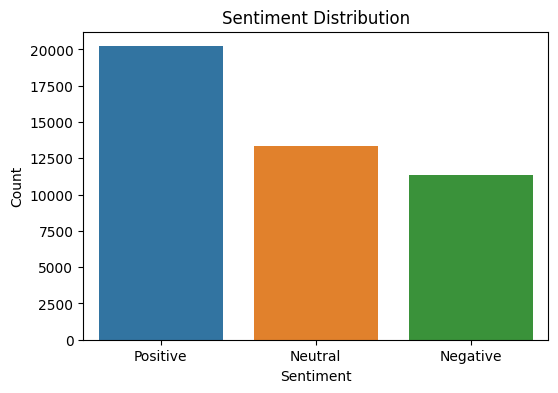

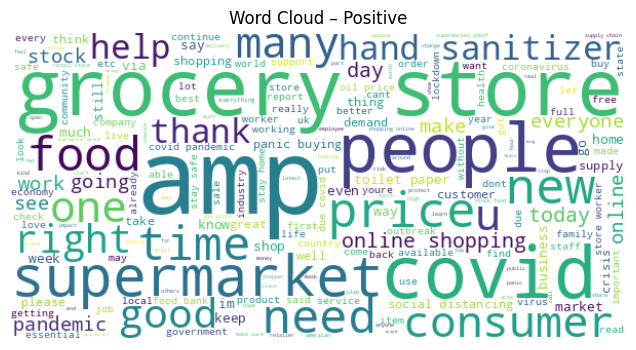

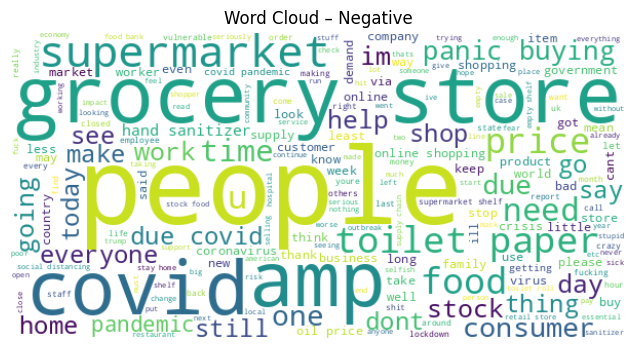

Positive Topic Charts


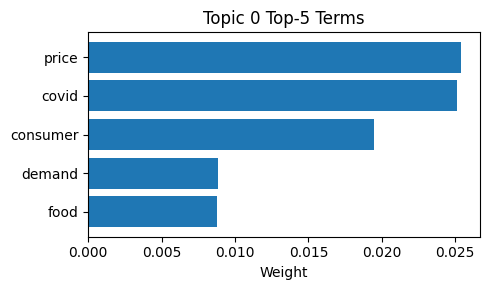

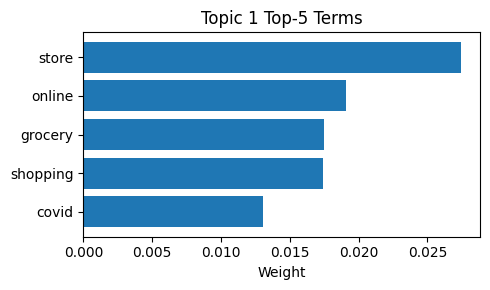

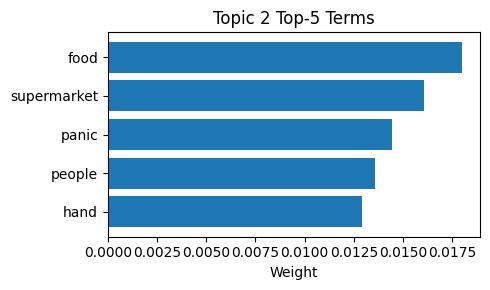

Negative Topic Charts


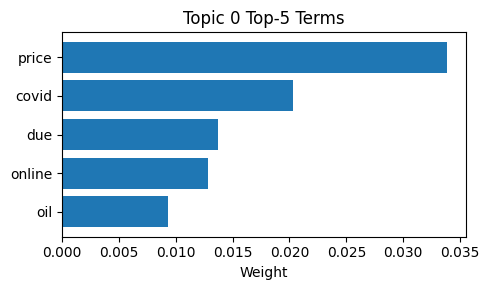

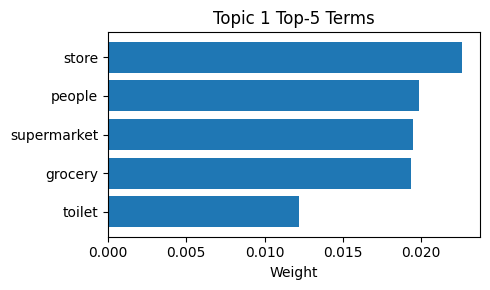

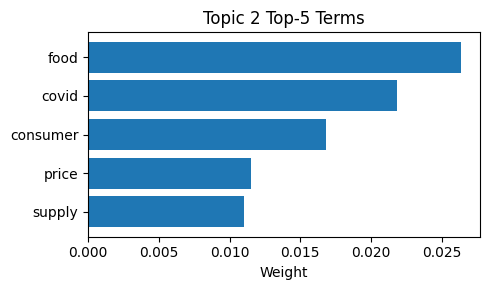

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

#Sentiment Distribution Plot
plt.figure(figsize=(6,4))
sns.countplot(x='SentimentLabel', data=df,
              order=['Positive','Neutral','Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

#Word Clouds
for label, texts in [('Positive', positive_texts), ('Negative', negative_texts)]:
    combined = ' '.join(texts)
    wc = WordCloud(width=600, height=300, background_color='white')\
         .generate(combined)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud – {label}')
    plt.show()

#Topic Charts
def plot_topic(lda_model, dictionary, topic_id, topn=5):
    terms = lda_model.get_topic_terms(topic_id, topn)
    words   = [dictionary[id] for id, _ in terms]
    weights = [w for _, w in terms]
    y = np.arange(len(words))
    plt.figure(figsize=(5,3))
    plt.barh(y, weights, align='center')
    plt.yticks(y, words)
    plt.gca().invert_yaxis()
    plt.title(f'Topic {topic_id} Top-{topn} Terms')
    plt.xlabel('Weight')
    plt.tight_layout()
    plt.show()

print("Positive Topic Charts")
for t in range(positive_lda.num_topics):
    plot_topic(positive_lda, positive_dict, t)

print("Negative Topic Charts")
for t in range(negative_lda.num_topics):
    plot_topic(negative_lda, negative_dict, t)

